# Turkish Lira Dataset

This project exploits the Turkish Lira Banknote Dataset available on Kaggle (https://www.kaggle.com/baltacifatih/turkish-lira-banknote-dataset) to implement from scratch an image classifier based on neural networks using Tensorflow.
The trained classifier must take an image as input and provide as output the corresponding predictions w.r.t. the 5, 10, 20, 500, 100, and 200 lira classes.

The dataset has already been divided into 5550 images for training and 450 for validation, for a grand total of 6000 images whose original shape is of 1280x720x3 (width, height and 3 RGB channels).

https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

Download the dataset and unzip it.

In [8]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('baltacifatih/turkish-lira-banknote-dataset', unzip=True)

In [9]:
import numpy as np
import pandas as pd
import pickle
import seaborn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [10]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [11]:
from skimage.io import imread
import glob
import re
import skimage
import cv2
from PIL import Image
%matplotlib inline

In [12]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Data analysis

We import the data and analyze it.

The original dataset comprehends a training and a test sets of images, therefore no further train/test split will be employed. The training set contains 5550 images, while the test set contains the remaining 450 images.

In [13]:
raw_turkish=[]
with open("train.txt") as file:
    raw_turkish=file.readlines()

In [14]:
imageDir=''

images_turkish={}
turkish_labels, img_name=[], []
for i in range(0, len(raw_turkish)):
    #read each line as a string
    s=raw_turkish[i]
    s.rstrip("\n")
    #split each line by the slash:
    slashSplit=s.split("/")
    images={}
    for x in slashSplit:
        label=slashSplit[0]
        imageName=slashSplit[1].rstrip("\n")
        d={label:(imageDir+str(label)+'/'+imageName)}
        images.update(d)
    
    turkish_labels.append(np.int32(label))
    img_name.append(imageDir+str(label)+'/'+imageName)
    raw_turkish[i]=images

In [15]:
df_turkish = pd.DataFrame.from_dict({'image':img_name,
                                     'label':turkish_labels})

In [16]:
df_turkish

,image,label
0,5/eminus_5_1_0062.png,5
1,5/eminus_5_2_0011.png,5
2,5/5_1_0147.png,5
3,5/5_1_0148.png,5
4,5/saltAndPeppered_5_1_0046.png,5
...,...,...
5545,200/200_1_0134.png,200
5546,200/200_1_0434.png,200
5547,200/eminus_200_1_0159.png,200
5548,200/eplus_200_1_0089.png,200


In [145]:
raw_valid=[]
with open("validation.txt") as file_valid:
    raw_valid=file_valid.readlines()

In [146]:
images_valid={}
valid_labels, img_name_valid=[], []
for i in range(0, len(raw_valid)):
    #read each line as a string
    sValid=raw_valid[i]
    sValid.rstrip("\n")
    #split each line by the slash:
    slashSplitValid=sValid.split("/")
    imagesValid={}
    for x in slashSplitValid:
        labelValid=slashSplitValid[0]
        imageNameValid=slashSplitValid[1].rstrip("\n")
        dValid={labelValid:(imageDir+str(labelValid)+'/'+imageNameValid)}
        imagesValid.update(dValid)
    
    valid_labels.append(np.int32(labelValid))
    img_name_valid.append(imageDir+str(labelValid)+'/'+imageNameValid)
    raw_valid[i]=imagesValid

In [147]:
df_valid= pd.DataFrame.from_dict({'image':img_name_valid,
                                  'label':valid_labels})
df_valid.head(5)

,image,label
0,C:/Users/liry9/Desktop/Malchiodi/turkish/5/epl...,5
1,C:/Users/liry9/Desktop/Malchiodi/turkish/5/5_1...,5
2,C:/Users/liry9/Desktop/Malchiodi/turkish/5/5_1...,5
3,C:/Users/liry9/Desktop/Malchiodi/turkish/5/5_1...,5
4,C:/Users/liry9/Desktop/Malchiodi/turkish/5/emi...,5


In [148]:
img=plt.imread(df_turkish.iloc[0]['image'])
height=img.shape[0]
width=img.shape[1]
channels=img.shape[2]
print('image shape: width={}, height={}, channels={}'.format(width, width, channels))

image shape: width=1280, height=1280, channels=3


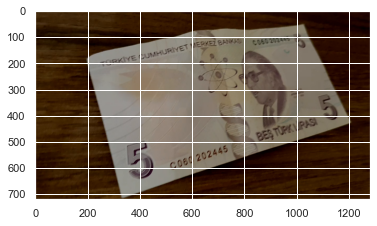

In [149]:
plt.imshow(img)

Let's analyze the distribution of the labels in order to check whether we need to adjust the class distribution of our dataset using for example oversampling or undersampling.

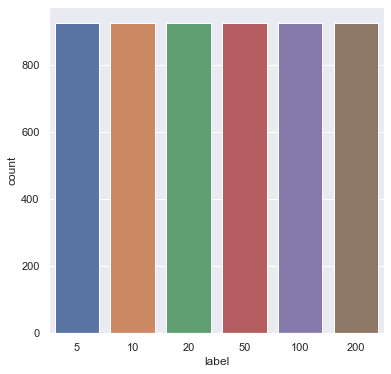

In [150]:
seaborn.set(rc={'figure.figsize':(6,6)})
seaborn.countplot(df_turkish['label'])

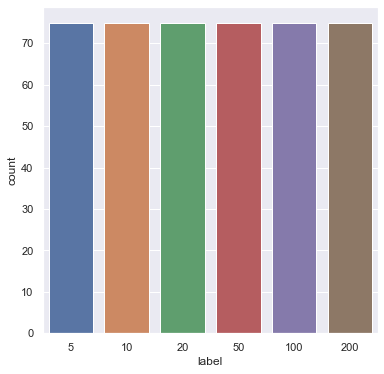

In [151]:
# Let's analyze the distribution of the labels
seaborn.set(rc={'figure.figsize':(6,6)})
seaborn.countplot(df_valid['label'])

As we can see the dataset is fully balanced therefore we do not need to implement any techniques of upsampling or downsampling.

# Preprocessing

In [152]:
import time
# get the starting time
startTime = time.time()

# initialize the empty lists
x_turkish=[]
y_turkish1=[]
dim=64

# for loop
for row in df_turkish.iterrows():
    image = cv2.imread(row[1][0])
    img_array = Image.fromarray(image, 'RGB')
    img_resized = img_array.resize((dim,dim))
    x_turkish.append(np.array(img_resized))
    y_turkish1.append(row[1][1])
    
# get time taken to run the for loop
elapsed_time_turkish = (time.time() - startTime)
print(elapsed_time_turkish/60)

2.304759140809377


In [153]:
# get the starting time
startTime = time.time()

# initialize the empty lists
x_valid=[]
y_valid1=[]
dim=64

# for loop
for row in df_valid.iterrows():
    image= cv2.imread(row[1][0])
    img_array = Image.fromarray(image, 'RGB')
    img_resized = img_array.resize((dim,dim))
    x_valid.append(np.array(img_resized))
    y_valid1.append(np.array(row[1][1]))
    
# get time taken to run the for loop
elapsed_time_valid = (time.time() - startTime)
print(elapsed_time_valid/60)

0.18502394358317056


In [154]:
x_turkish=np.array(x_turkish)
y_turkish1=np.array(y_turkish1)
x_valid=np.array(x_valid)
y_valid1=np.array(y_valid1)

In [155]:
x_turkish.shape

(5550, 64, 64, 3)

In [156]:
y_turkish=[]
for i in y_turkish1:
    if (i==5):
        y_turkish.append([0])
    elif (i==10):
        y_turkish.append([1])
    elif (i==20):
        y_turkish.append([2])
    elif (i==50):
        y_turkish.append([3])
    elif (i==100):
        y_turkish.append([4])
    elif (i==200):
        y_turkish.append([5])

In [157]:
y_valid=[]
for i in y_valid1:
    if (i==5):
        y_valid.append([0])
    elif (i==10):
        y_valid.append([1])
    elif (i==20):
        y_valid.append([2])
    elif (i==50):
        y_valid.append([3])
    elif (i==100):
        y_valid.append([4])
    elif (i==200):
        y_valid.append([5])

In [158]:
y_turkish=np.array(y_turkish)
y_valid=np.array(y_valid)

In [159]:
x_train, x_test, y_train, y_test = train_test_split(x_turkish, y_turkish, test_size=0.2, random_state=42)

In [160]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4440, 64, 64, 3) (1110, 64, 64, 3) (4440, 1) (1110, 1)


In [161]:
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))

In [162]:
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(4440, 1)
(1110, 1)
(450, 1)


[0]


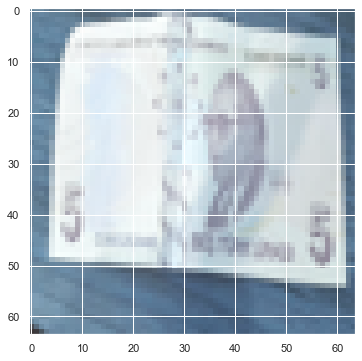

In [163]:
plt.imshow(x_valid[0])
print(y_valid[0])

array([3])

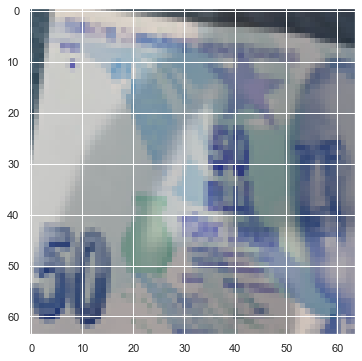

In [164]:
plt.imshow(x_train[0])
y_train[0]

array([2])

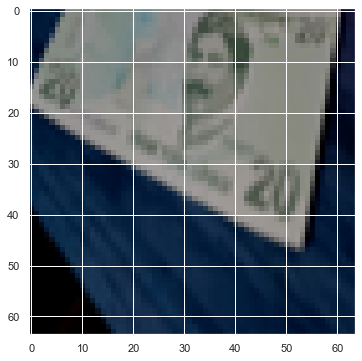

In [165]:
plt.imshow(x_test[0])
y_test[0]

# Grayscale conversion of the images

We will use the tf.image.rgb_to_grayscale function, which converts more efficiently one or more images from RGB to Grayscale.

In [166]:
x_train_gray = tf.image.rgb_to_grayscale(x_train)
x_valid_gray = tf.image.rgb_to_grayscale(x_valid)
x_test_gray = tf.image.rgb_to_grayscale(x_test)

In [167]:
print(x_train_gray.shape, x_test_gray.shape, x_valid_gray.shape)

(4440, 64, 64, 1) (1110, 64, 64, 1) (450, 64, 64, 1)


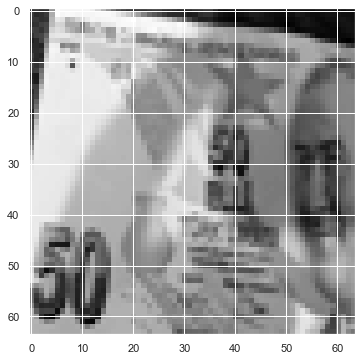

In [168]:
dim = 64
plt.imshow(tf.reshape(x_train_gray[0],[dim, dim]), cmap = "gray")

# RGB color model

It seems appropriate to briefly introduce the RGB color model. A color model is an abstract mathematical model describing the way colors can be represented as tuples of numbers, typically as three (as in our case) or four values or color components. The RGB model is an additive color model since the perceived color can be predicted by summing the numeric representations of the component colors which in this model are Red, Green and Blue.

We need to:
- convert the labels to one hot encoding format;
- rescale pixel intensity values in the interval [0,1]
https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

In [169]:
# RGB scale version
train_set_size=x_train.shape[0]
valid_set_size=x_valid.shape[0]
test_set_size=x_test.shape[0]
img_dim=np.int32(64)
dim=64
rgb=3
max_value=255.0

# one hot encoding
y_train_hot = to_categorical(y_train, 6)
y_valid_hot = to_categorical(y_valid, 6)
y_test_hot = to_categorical(y_test, 6)

# rescale in [0,1]
x_train = tf.cast(x_train, tf.float32) / max_value
x_valid = tf.cast(x_valid, tf.float32) / max_value
x_test = tf.cast(x_test, tf.float32) / max_value

In [170]:
# RGB flatted images
# flatten the images
x_train_flat = tf.reshape(x_train, [train_set_size, img_dim * img_dim * 3])
x_test_flat = tf.reshape(x_test, [test_set_size, img_dim * img_dim * 3])
x_valid_flat = tf.reshape(x_valid, [valid_set_size, img_dim * img_dim * 3])

# rescale in [0,1]
x_train_flat = tf.cast(x_train_flat, tf.float32) / max_value
x_valid_flat = tf.cast(x_valid_flat, tf.float32) / max_value
x_test_flat = tf.cast(x_test_flat, tf.float32) / max_value

In [171]:
x_train.shape

TensorShape([4440, 64, 64, 3])

In [172]:
# Gray scale version
train_gray_size=x_train_gray.shape[0]
valid_gray_size=x_valid_gray.shape[0]
test_gray_size=x_test_gray.shape[0]
img_dim=np.int32(64)
max_value=np.float32(255.0)

# rescale the flatted images in [0,1]
x_train_gray = tf.cast(x_train_gray, tf.float32) / max_value
x_valid_gray = tf.cast(x_valid_gray, tf.float32) / max_value
x_test_gray = tf.cast(x_test_gray, tf.float32) / max_value

In [173]:
# Grayscale flatted images
# flatten the images
x_train_gray_flat = tf.reshape(x_train_gray, [train_gray_size, img_dim * img_dim])
x_test_gray_flat = tf.reshape(x_test_gray, [test_gray_size, img_dim * img_dim])
x_valid_gray_flat = tf.reshape(x_valid_gray, [valid_gray_size, img_dim * img_dim])

# rescale the flatted images in [0,1]
x_train_gray_flat = tf.cast(x_train_gray_flat, tf.float32) / max_value
x_valid_gray_flat = tf.cast(x_valid_gray_flat, tf.float32) / max_value
x_test_gray_flat = tf.cast(x_test_gray_flat, tf.float32) / max_value

In [174]:
print(x_train_gray_flat.shape, y_train_hot.shape, x_test_gray_flat.shape, y_test_hot.shape)

(4440, 4096) (4440, 6) (1110, 4096) (1110, 6)


# PCA

In [175]:
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

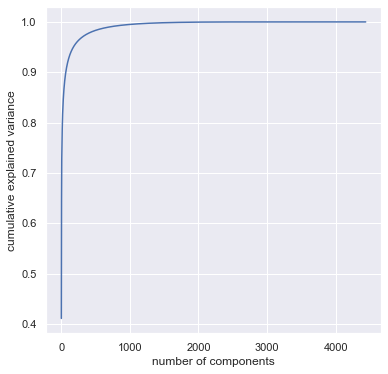

In [176]:
x_pca=PCA().fit(x_train_flat)
plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [177]:
pca_rgb = PCA(0.9)

In [178]:
train_rgb = pca_rgb.fit(x_train_flat)
valid_rgb = pca_rgb.fit(x_valid_flat)
test_rgb = pca_rgb.fit(x_test_flat)

In [179]:
pca_rgb.n_components_

62

In [186]:
train_pca = pca_rgb.transform(x_train_flat)
valid_pca = pca_rgb.transform(x_valid_flat)
test_pca = pca_rgb.transform(x_test_flat)

# Feed-forward neural networks

To build an image classifier we proceed as follows:
- convert RGB images in grayscale,
- flatten the images;
- build a feed-forward neural network;
- tune the network to improve the accuracy.

We also modify the visualization of the labels of the test set.

In [60]:
y_test_orig=[]
for elem in y_test:
    y_test_orig.append(elem[0])

We then test a one layer feed-forward neural network with 64 neurons.

In [54]:
model_one_layer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4096,)),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_one_layer.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model_one_layer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 24582     
Total params: 16,805,894
Trainable params: 16,805,894
Non-trainable params: 0
_________________________________________________________________


In [55]:
history_one_layer= model_one_layer.fit(x_train_gray_flat, y_train_hot,
                                       batch_size=64,
                                       epochs=10,
                                       validation_data=(x_valid_gray_flat, y_valid_hot))       

Epoch 1/10
70/70 [==============================] - 6s 90ms/step - loss: 0.4457 - accuracy: 0.2275 - val_loss: 0.4331 - val_accuracy: 0.2844
Epoch 2/10
70/70 [==============================] - 6s 88ms/step - loss: 0.4296 - accuracy: 0.2912 - val_loss: 0.4208 - val_accuracy: 0.3267
Epoch 3/10
70/70 [==============================] - 6s 91ms/step - loss: 0.4206 - accuracy: 0.3160 - val_loss: 0.4141 - val_accuracy: 0.3622
Epoch 4/10
70/70 [==============================] - 6s 89ms/step - loss: 0.4132 - accuracy: 0.3385 - val_loss: 0.4076 - val_accuracy: 0.3622
Epoch 5/10
70/70 [==============================] - 6s 90ms/step - loss: 0.4047 - accuracy: 0.3637 - val_loss: 0.4035 - val_accuracy: 0.3822
Epoch 6/10
70/70 [==============================] - 6s 90ms/step - loss: 0.4008 - accuracy: 0.3745 - val_loss: 0.4016 - val_accuracy: 0.4111
Epoch 7/10
70/70 [==============================] - 6s 89ms/step - loss: 0.3922 - accuracy: 0.4097 - val_loss: 0.3958 - val_accuracy: 0.4044
Epoch 8/10
70

In [56]:
model_predict_one_layer = model_one_layer.evaluate(x_test_gray_flat, y_test_hot, batch_size=100)

12/12 [==============================] - 0s 21ms/step - loss: 0.3672 - accuracy: 0.4955


In [57]:
pred_labels_one_layer=model_one_layer.predict_classes(x_test_gray_flat)

In [58]:
y_pred_one_layer=[]
for elem in pred_labels_one_layer:
    y_pred_one_layer.append(elem)

In [61]:
df_one_layer=pd.DataFrame({'Original labels':y_test_orig,
                           'Predicted labels':y_pred_one_layer})
df_one_layer

,Original labels,Predicted labels
0,2,0
1,5,1
2,4,1
3,0,4
4,3,1
...,...,...
1105,5,1
1106,1,5
1107,1,1
1108,3,0


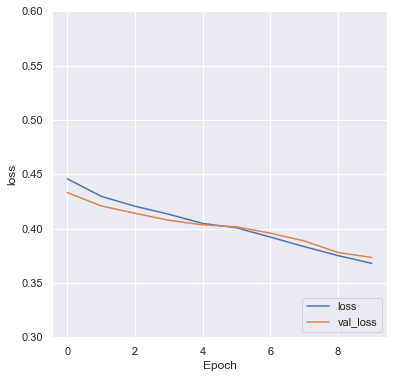

In [79]:
plt.plot(history_one_layer.history['loss'], label='loss')
plt.plot(history_one_layer.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.3, 0.6])
plt.legend(loc='lower right')

Two layer Network

In [63]:
model_two_layer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4096,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_two_layer.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model_two_layer.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                262208    
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 102       
Total params: 263,350
Trainable params: 263,350
Non-trainable params: 0
_________________________________________________________________


In [80]:
history_two_layer= model_two_layer.fit(x_train_gray_flat, y_train_hot,
                                       epochs=20,
                                       batch_size=64,
                                       validation_data=(x_valid_gray_flat, y_valid_hot))      

Epoch 1/20
70/70 [==============================] - 0s 4ms/step - loss: 0.4002 - accuracy: 0.3849 - val_loss: 0.3994 - val_accuracy: 0.3933
Epoch 2/20
70/70 [==============================] - 0s 4ms/step - loss: 0.3984 - accuracy: 0.3899 - val_loss: 0.4007 - val_accuracy: 0.3644
Epoch 3/20
70/70 [==============================] - 0s 4ms/step - loss: 0.3973 - accuracy: 0.3896 - val_loss: 0.3985 - val_accuracy: 0.3822
Epoch 4/20
70/70 [==============================] - 0s 4ms/step - loss: 0.3949 - accuracy: 0.3980 - val_loss: 0.3959 - val_accuracy: 0.3867
Epoch 5/20
70/70 [==============================] - 0s 4ms/step - loss: 0.3930 - accuracy: 0.4043 - val_loss: 0.3939 - val_accuracy: 0.4089
Epoch 6/20
70/70 [==============================] - 0s 4ms/step - loss: 0.3909 - accuracy: 0.4063 - val_loss: 0.3968 - val_accuracy: 0.3889
Epoch 7/20
70/70 [==============================] - 0s 4ms/step - loss: 0.3890 - accuracy: 0.4151 - val_loss: 0.3917 - val_accuracy: 0.4000
Epoch 8/20
70/70 [==

In [81]:
model_predict_two_layer = model_two_layer.evaluate(x_test_gray_flat,
                                                   y_test_hot,
                                                   batch_size=100)

12/12 [==============================] - 0s 2ms/step - loss: 0.3695 - accuracy: 0.4811


In [82]:
pred_labels_two_layer=model_two_layer.predict_classes(x_test_gray_flat)

In [83]:
y_pred_two_layer=[]
for elem in pred_labels_two_layer:
    y_pred_two_layer.append(elem)

In [84]:
df_two_layer=pd.DataFrame({'Original labels':y_test_orig,
                           'Predicted labels':y_pred_two_layer})
df_two_layer

,Original labels,Predicted labels
0,2,0
1,5,4
2,4,4
3,0,4
4,3,2
...,...,...
1105,5,5
1106,1,4
1107,1,1
1108,3,0


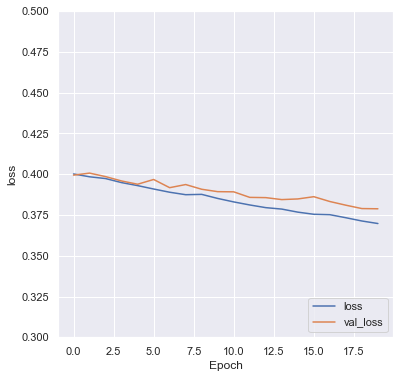

In [96]:
plt.plot(history_two_layer.history['loss'], label='loss')
plt.plot(history_two_layer.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.3, 0.5])
plt.legend(loc='lower right')

Three layer network

In [86]:
model_three_layer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4096,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_three_layer.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model_three_layer.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                262208    
_________________________________________________________________
dense_13 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 54        
Total params: 263,438
Trainable params: 263,438
Non-trainable params: 0
_________________________________________________________________


In [87]:
history_three_layer= model_three_layer.fit(x_train_gray_flat, y_train_hot,
                                       epochs=20,
                                       batch_size=64,
                                       validation_data=(x_valid_gray_flat, y_valid_hot))       

Epoch 1/20
70/70 [==============================] - 0s 5ms/step - loss: 0.4501 - accuracy: 0.1813 - val_loss: 0.4490 - val_accuracy: 0.1956
Epoch 2/20
70/70 [==============================] - 0s 3ms/step - loss: 0.4479 - accuracy: 0.1991 - val_loss: 0.4445 - val_accuracy: 0.2556
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 0.4434 - accuracy: 0.2356 - val_loss: 0.4400 - val_accuracy: 0.2400
Epoch 4/20
70/70 [==============================] - 0s 3ms/step - loss: 0.4388 - accuracy: 0.2351 - val_loss: 0.4343 - val_accuracy: 0.2422
Epoch 5/20
70/70 [==============================] - 0s 4ms/step - loss: 0.4347 - accuracy: 0.2491 - val_loss: 0.4303 - val_accuracy: 0.2556
Epoch 6/20
70/70 [==============================] - 0s 3ms/step - loss: 0.4311 - accuracy: 0.2599 - val_loss: 0.4276 - val_accuracy: 0.2667
Epoch 7/20
70/70 [==============================] - 0s 4ms/step - loss: 0.4286 - accuracy: 0.2640 - val_loss: 0.4268 - val_accuracy: 0.2711
Epoch 8/20
70/70 [==

In [88]:
model_predict_three_layer = model_three_layer.evaluate(x_test_gray_flat,
                                                       y_test_hot,
                                                       batch_size=100)

12/12 [==============================] - 0s 2ms/step - loss: 0.4012 - accuracy: 0.3820


In [89]:
pred_labels_three_layer = model_three_layer.predict_classes(x_test_gray_flat)

In [90]:
y_pred_three_layer=[]
for elem in pred_labels_three_layer:
    y_pred_three_layer.append(elem)

In [91]:
df_three_layer=pd.DataFrame({'Original labels':y_test_orig,
                             'Predicted labels':y_pred_three_layer})
df_three_layer

,Original labels,Predicted labels
0,2,5
1,5,5
2,4,4
3,0,4
4,3,2
...,...,...
1105,5,5
1106,1,5
1107,1,4
1108,3,4


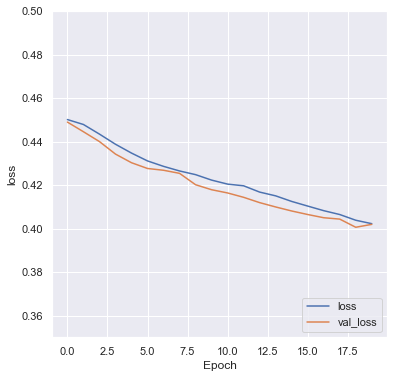

In [94]:
plt.plot(history_three_layer.history['loss'], label='loss')
plt.plot(history_three_layer.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.35, 0.5])
plt.legend(loc='lower right')

# CNN

In order to avoid the loss of shape information especially important with image classification we try with convolutional neural network.

One VGG block

In [98]:
model_one_vgg = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_one_vgg.compile(optimizer = "adam",
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_one_vgg.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 390       
Total params: 2,117,862
Trainable params: 2,117,862
Non-trainable params: 0
____________________________________________

In [99]:
train_one_vgg = model_one_vgg.fit(x_train, y_train_hot,
                                  epochs=10,
                                  batch_size=10,
                                  validation_data=(x_valid, y_valid_hot))

test_one_vgg = model_one_vgg.evaluate(x_test,
                                      y_test_hot,
                                      verbose=0)       

Epoch 1/10
444/444 [==============================] - 40s 91ms/step - loss: 0.2388 - accuracy: 0.6554 - val_loss: 0.1201 - val_accuracy: 0.8511
Epoch 2/10
444/444 [==============================] - 40s 90ms/step - loss: 0.0704 - accuracy: 0.9205 - val_loss: 0.0648 - val_accuracy: 0.9289
Epoch 3/10
444/444 [==============================] - 41s 92ms/step - loss: 0.0347 - accuracy: 0.9592 - val_loss: 0.0323 - val_accuracy: 0.9622
Epoch 4/10
444/444 [==============================] - 41s 92ms/step - loss: 0.0328 - accuracy: 0.9635 - val_loss: 0.0402 - val_accuracy: 0.9667
Epoch 5/10
444/444 [==============================] - 41s 92ms/step - loss: 0.0160 - accuracy: 0.9836 - val_loss: 0.0206 - val_accuracy: 0.9800
Epoch 6/10
444/444 [==============================] - 41s 93ms/step - loss: 0.0292 - accuracy: 0.9698 - val_loss: 0.0226 - val_accuracy: 0.9822
Epoch 7/10
444/444 [==============================] - 42s 95ms/step - loss: 0.0152 - accuracy: 0.9856 - val_loss: 0.0461 - val_accuracy:

In [100]:
pred_labels_one_vgg = model_one_vgg.predict_classes(x_test)

In [101]:
y_pred_one_vgg=[]
for elem in pred_labels_one_vgg:
    y_pred_one_vgg.append(elem)

In [102]:
df_one_vgg=pd.DataFrame({'Original labels':y_test_orig,
                         'Predicted labels':y_pred_one_vgg})
df_one_vgg

,Original labels,Predicted labels
0,2,2
1,5,5
2,4,4
3,0,0
4,3,3
...,...,...
1105,5,5
1106,1,1
1107,1,1
1108,3,3


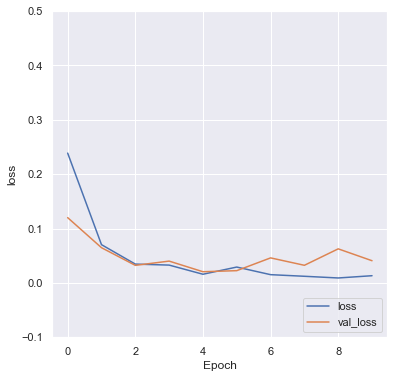

In [103]:
plt.plot(train_one_vgg.history['loss'], label='loss')
plt.plot(train_one_vgg.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-0.1, 0.5])
plt.legend(loc='lower right')

VGG with two layers

In [104]:
model_two_vgg = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_two_vgg.compile(optimizer = "adam",
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_two_vgg.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)            

In [105]:
train_two_vgg = model_two_vgg.fit(x_train, y_train_hot,
                                  epochs=10,
                                  batch_size=10,
                                  validation_data=(x_valid,
                                                   y_valid_hot))

test_two_vgg = model_two_vgg.evaluate(x_test,
                                      y_test_hot,
                                      verbose=0)       

Epoch 1/10
444/444 [==============================] - 96s 216ms/step - loss: 0.4326 - accuracy: 0.2644 - val_loss: 0.4158 - val_accuracy: 0.3400
Epoch 2/10
444/444 [==============================] - 99s 224ms/step - loss: 0.2177 - accuracy: 0.7135 - val_loss: 0.1232 - val_accuracy: 0.8400
Epoch 3/10
444/444 [==============================] - 100s 226ms/step - loss: 0.0679 - accuracy: 0.9245 - val_loss: 0.0435 - val_accuracy: 0.9489
Epoch 4/10
444/444 [==============================] - 102s 229ms/step - loss: 0.0334 - accuracy: 0.9649 - val_loss: 0.0290 - val_accuracy: 0.9667
Epoch 5/10
444/444 [==============================] - 98s 221ms/step - loss: 0.0172 - accuracy: 0.9827 - val_loss: 0.0202 - val_accuracy: 0.9800
Epoch 6/10
444/444 [==============================] - 98s 222ms/step - loss: 0.0076 - accuracy: 0.9926 - val_loss: 0.0463 - val_accuracy: 0.9644
Epoch 7/10
444/444 [==============================] - 98s 221ms/step - loss: 0.0202 - accuracy: 0.9809 - val_loss: 0.0403 - val_

In [106]:
pred_labels_two_vgg = model_two_vgg.predict_classes(x_test)

In [107]:
y_pred_two_vgg=[]
for elem in pred_labels_two_vgg:
    y_pred_two_vgg.append(elem)

In [108]:
df_two_vgg=pd.DataFrame({'Original labels':y_test_orig,
                         'Predicted labels':y_pred_two_vgg})
df_two_vgg

,Original labels,Predicted labels
0,2,2
1,5,5
2,4,4
3,0,0
4,3,3
...,...,...
1105,5,5
1106,1,1
1107,1,1
1108,3,3


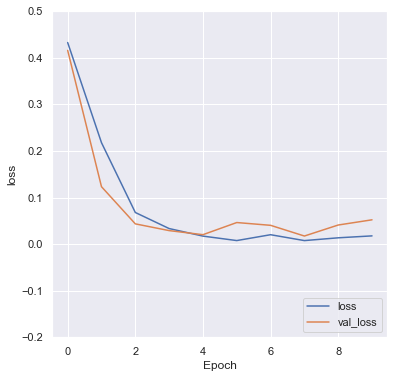

In [111]:
plt.plot(train_two_vgg.history['loss'], label='loss')
plt.plot(train_two_vgg.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-0.2, 0.5])
plt.legend(loc='lower right')

VGG with 3 layers

In [112]:
model_three_vgg = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_three_vgg.compile(optimizer = "adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [113]:
train_three_vgg = model_three_vgg.fit(x_train, y_train_hot,
                                    epochs=10,
                                    batch_size=10,
                                    validation_data=(x_valid,
                                                     y_valid_hot))

test_three_vgg = model_three_vgg.evaluate(x_test,
                                          y_test_hot,
                                          verbose=0)  

pred_labels_three_vgg = model_three_vgg.predict_classes(x_test)

Epoch 1/10
444/444 [==============================] - 141s 318ms/step - loss: 0.4510 - accuracy: 0.1640 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 2/10
444/444 [==============================] - 140s 315ms/step - loss: 0.4506 - accuracy: 0.1707 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 3/10
444/444 [==============================] - 141s 317ms/step - loss: 0.4506 - accuracy: 0.1689 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 4/10
444/444 [==============================] - 142s 320ms/step - loss: 0.4506 - accuracy: 0.1716 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 5/10
444/444 [==============================] - 148s 334ms/step - loss: 0.4506 - accuracy: 0.1716 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 6/10
444/444 [==============================] - 148s 334ms/step - loss: 0.4506 - accuracy: 0.1700 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 7/10
444/444 [==============================] - 148s 332ms/step - loss: 0.4506 - accuracy: 0.1678 - val_loss: 0.4506 -

In [114]:
y_pred_three_vgg=[]
for elem in pred_labels_three_vgg:
    y_pred_three_vgg.append(elem)

In [115]:
df_three_vgg=pd.DataFrame({'Original labels':y_test_orig,
                         'Predicted labels':y_pred_three_vgg})
df_three_vgg

,Original labels,Predicted labels
0,2,4
1,5,4
2,4,4
3,0,4
4,3,4
...,...,...
1105,5,4
1106,1,4
1107,1,4
1108,3,4


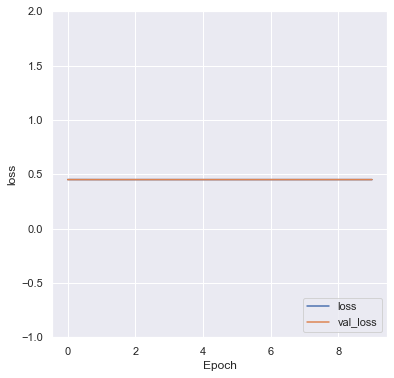

In [116]:
plt.plot(train_three_vgg.history['loss'], label='loss')
plt.plot(train_three_vgg.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-1, 2])
plt.legend(loc='lower right')

2 VGG blocks with Dropout

In [117]:
model_two_vgg_drop = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_two_vgg_drop.compile(optimizer = "adam",
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_two_vgg_drop.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)      

In [118]:
train_two_vgg_drop = model_two_vgg_drop.fit(x_train, y_train_hot,
                                    epochs=10,
                                    batch_size=10,
                                    validation_data=(x_valid, y_valid_hot))

test_two_vgg_drop = model_two_vgg_drop.evaluate(x_test,
                                                y_test_hot,
                                                verbose=0)  

pred_labels_two_vgg_drop = model_two_vgg_drop.predict_classes(x_test)

Epoch 1/10
444/444 [==============================] - 98s 220ms/step - loss: 0.4497 - accuracy: 0.2086 - val_loss: 0.4297 - val_accuracy: 0.2956
Epoch 2/10
444/444 [==============================] - 98s 221ms/step - loss: 0.4027 - accuracy: 0.3689 - val_loss: 0.3415 - val_accuracy: 0.5044
Epoch 3/10
444/444 [==============================] - 101s 227ms/step - loss: 0.2731 - accuracy: 0.6252 - val_loss: 0.1887 - val_accuracy: 0.7644
Epoch 4/10
444/444 [==============================] - 102s 229ms/step - loss: 0.1457 - accuracy: 0.8268 - val_loss: 0.0943 - val_accuracy: 0.8911
Epoch 5/10
444/444 [==============================] - 104s 234ms/step - loss: 0.0845 - accuracy: 0.9025 - val_loss: 0.0590 - val_accuracy: 0.9444
Epoch 6/10
444/444 [==============================] - 105s 236ms/step - loss: 0.0464 - accuracy: 0.9502 - val_loss: 0.0902 - val_accuracy: 0.8933
Epoch 7/10
444/444 [==============================] - 102s 230ms/step - loss: 0.0363 - accuracy: 0.9588 - val_loss: 0.0373 - v

In [119]:
y_pred_two_vgg_drop = []
for elem in pred_labels_two_vgg_drop:
    y_pred_two_vgg_drop.append(elem)

In [120]:
df_two_vgg_drop=pd.DataFrame({'Original labels':y_test_orig,
                              'Predicted labels':y_pred_two_vgg_drop})
df_two_vgg_drop

,Original labels,Predicted labels
0,2,2
1,5,5
2,4,4
3,0,0
4,3,3
...,...,...
1105,5,5
1106,1,1
1107,1,1
1108,3,3


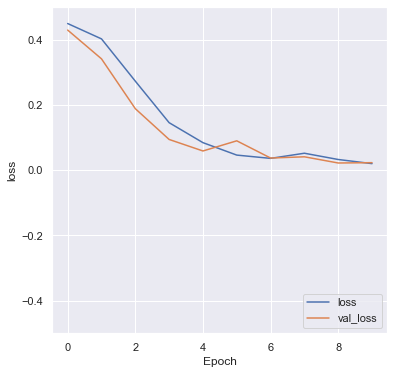

In [127]:
plt.plot(train_two_vgg_drop.history['loss'], label='loss')
plt.plot(train_two_vgg_drop.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-0.5, 0.5])
plt.legend(loc='lower right')

Two VGG blocks with Dropout and BatchNormalization

In [122]:
model_two_vgg_drop_batch = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_two_vgg_drop_batch.compile(optimizer = "adam",
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_two_vgg_drop_batch.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 128)      

In [123]:
train_two_vgg_drop_batch = model_two_vgg_drop_batch.fit(x_train, y_train_hot,
                                    epochs=10,
                                    batch_size=10,
                                    validation_data=(x_valid, y_valid_hot))

test_two_vgg_drop_batch = model_two_vgg_drop_batch.evaluate(x_test, y_test_hot, verbose=0)  

pred_labels_two_vgg_drop_batch = model_two_vgg_drop_batch.predict_classes(x_test)

Epoch 1/10
444/444 [==============================] - 168s 378ms/step - loss: 0.2528 - accuracy: 0.6635 - val_loss: 0.3727 - val_accuracy: 0.5000
Epoch 2/10
444/444 [==============================] - 164s 370ms/step - loss: 0.0922 - accuracy: 0.8939 - val_loss: 3.1588 - val_accuracy: 0.1800
Epoch 3/10
444/444 [==============================] - 165s 371ms/step - loss: 0.0918 - accuracy: 0.8989 - val_loss: 2.7725 - val_accuracy: 0.2044
Epoch 4/10
444/444 [==============================] - 166s 375ms/step - loss: 0.0916 - accuracy: 0.8968 - val_loss: 0.1133 - val_accuracy: 0.8578
Epoch 5/10
444/444 [==============================] - 173s 390ms/step - loss: 0.0466 - accuracy: 0.9511 - val_loss: 0.0236 - val_accuracy: 0.9778
Epoch 6/10
444/444 [==============================] - 171s 386ms/step - loss: 0.0438 - accuracy: 0.9559 - val_loss: 0.0132 - val_accuracy: 0.9911
Epoch 7/10
444/444 [==============================] - 166s 374ms/step - loss: 0.0290 - accuracy: 0.9716 - val_loss: 0.2692 -

In [124]:
y_pred_two_vgg_drop_batch = []
for elem in pred_labels_two_vgg_drop_batch:
    y_pred_two_vgg_drop_batch.append(elem)

In [125]:
df_two_vgg_drop_batch=pd.DataFrame({'Original labels':y_test_orig,
                                    'Predicted labels':y_pred_two_vgg_drop_batch})
df_two_vgg_drop_batch

,Original labels,Predicted labels
0,2,2
1,5,5
2,4,4
3,0,0
4,3,3
...,...,...
1105,5,5
1106,1,1
1107,1,1
1108,3,3


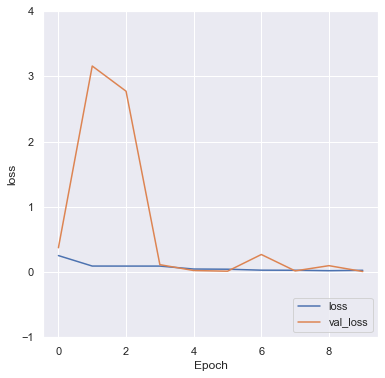

In [129]:
plt.plot(train_two_vgg_drop_batch.history['loss'], label='loss')
plt.plot(train_two_vgg_drop_batch.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-1, 4])
plt.legend(loc='lower right')

Grayscale images

In [130]:
model_gray = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_gray.compile(optimizer = "adam",
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_gray.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 128)     

In [131]:
train_gray = model_gray.fit(x_train_gray, y_train_hot,
                                    epochs=10,
                                    batch_size=10,
                                    validation_data=(x_valid_gray, y_valid_hot))

test_gray = model_gray.evaluate(x_test_gray, y_test_hot, verbose=0)  

pred_labels_gray = model_gray.predict_classes(x_test_gray)

Epoch 1/10
444/444 [==============================] - 148s 333ms/step - loss: 0.4345 - accuracy: 0.3732 - val_loss: 0.4567 - val_accuracy: 0.3089
Epoch 2/10
444/444 [==============================] - 161s 363ms/step - loss: 0.3255 - accuracy: 0.5480 - val_loss: 0.2738 - val_accuracy: 0.6511
Epoch 3/10
444/444 [==============================] - 163s 367ms/step - loss: 0.2412 - accuracy: 0.6903 - val_loss: 0.2691 - val_accuracy: 0.6267
Epoch 4/10
444/444 [==============================] - 173s 390ms/step - loss: 0.2168 - accuracy: 0.7257 - val_loss: 0.2743 - val_accuracy: 0.6222
Epoch 5/10
444/444 [==============================] - 163s 366ms/step - loss: 0.1625 - accuracy: 0.8052 - val_loss: 0.1490 - val_accuracy: 0.8000
Epoch 6/10
444/444 [==============================] - 162s 364ms/step - loss: 0.1283 - accuracy: 0.8520 - val_loss: 0.3152 - val_accuracy: 0.6556
Epoch 7/10
444/444 [==============================] - 159s 358ms/step - loss: 0.1370 - accuracy: 0.8396 - val_loss: 0.1062 -

In [132]:
y_pred_gray = []
for elem in pred_labels_gray:
    y_pred_gray.append(elem)

In [133]:
df_gray=pd.DataFrame({'Original labels':y_test_orig,
                      'Predicted labels':y_pred_gray})
df_gray

,Original labels,Predicted labels
0,2,2
1,5,2
2,4,2
3,0,2
4,3,2
...,...,...
1105,5,1
1106,1,0
1107,1,2
1108,3,2


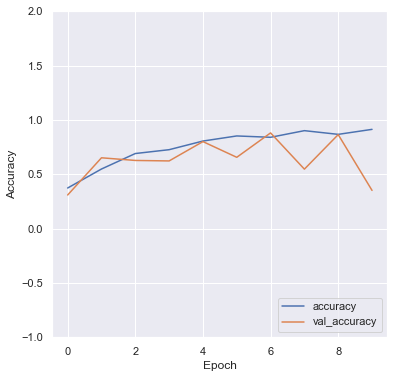

In [134]:
plt.plot(train_gray.history['accuracy'], label='accuracy')
plt.plot(train_gray.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([-1, 2])
plt.legend(loc='lower right')

2 VGG with Dropout and BatchNormalization using the features of the PCA.
- rgb scale first,
- grayscale second.

In [184]:
print(train_rgb)

PCA(n_components=0.9)


In [190]:
model_pca = Sequential()
model_pca.add(Dense(1024, activation='relu', input_shape=(62,)))
model_pca.add(Dense(1024, activation='relu'))
model_pca.add(Dense(512, activation='relu'))
model_pca.add(Dense(256, activation='relu'))
model_pca.add(Dense(6, activation='softmax'))

model_pca.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [191]:
history_pca = model_pca.fit(train_pca, y_train_hot,
                                    epochs=10,
                                    batch_size=10,
                                    validation_data=(valid_pca, y_valid_hot))

history_test_pca = model_pca.evaluate(test_pca, y_test_hot, verbose=0)  

pred_labels_pca = model_pca.predict_classes(test_pca)

Epoch 1/10
444/444 [==============================] - 5s 12ms/step - loss: 1.3456 - accuracy: 0.4115 - val_loss: 0.8880 - val_accuracy: 0.6289
Epoch 2/10
444/444 [==============================] - 5s 11ms/step - loss: 0.7449 - accuracy: 0.7189 - val_loss: 0.6017 - val_accuracy: 0.7733
Epoch 3/10
444/444 [==============================] - 5s 12ms/step - loss: 0.5340 - accuracy: 0.8061 - val_loss: 0.4551 - val_accuracy: 0.8267
Epoch 4/10
444/444 [==============================] - 5s 12ms/step - loss: 0.4027 - accuracy: 0.8592 - val_loss: 0.3312 - val_accuracy: 0.8733
Epoch 5/10
444/444 [==============================] - 5s 11ms/step - loss: 0.3224 - accuracy: 0.8908 - val_loss: 0.3051 - val_accuracy: 0.8978
Epoch 6/10
444/444 [==============================] - 5s 12ms/step - loss: 0.2958 - accuracy: 0.9027 - val_loss: 0.3411 - val_accuracy: 0.8756
Epoch 7/10
444/444 [==============================] - 5s 12ms/step - loss: 0.2397 - accuracy: 0.9227 - val_loss: 0.2355 - val_accuracy: 0.9289

In [192]:
y_pred_pca = []
for elem in pred_labels_pca:
    y_pred_pca.append(elem)

In [195]:
df_pca=pd.DataFrame({'Original labels':y_test_orig,
                     'Predicted labels':y_pred_pca})
df_pca

,Original labels,Predicted labels
0,2,0
1,5,5
2,4,4
3,0,0
4,3,3
...,...,...
1105,5,5
1106,1,1
1107,1,1
1108,3,3


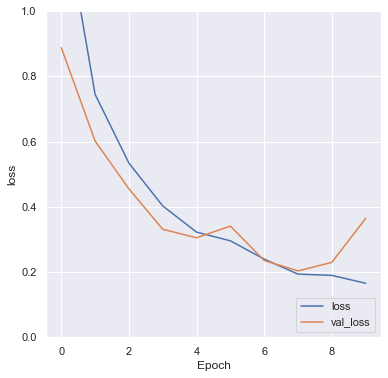

In [198]:
plt.plot(history_pca.history['loss'], label='loss')
plt.plot(history_pca.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')